In [1]:
# 1. IMPORTS Y CONFIGURACIÓN INICIAL
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates



In [2]:
# Configuración de estilos para el gráfico
plt.style.use('seaborn-v0_8-darkgrid')

# ----------------------------------------------------
# 2. DEFINICIÓN DE CONSTANTES DEL PORTAFOLIO Y ESCENARIOS
# ----------------------------------------------------

# Tickers y pesos de tu portafolio
TICKERS = ['SPYG', 'SMH', 'BRK-B', 'VTI', 'IEMG']
WEIGHTS = np.array([0.35, 0.16, 0.25, 0.14, 0.10])
# Asegúrate de que los pesos sumen 1 (100%)
assert np.isclose(WEIGHTS.sum(), 1.0), "Los pesos deben sumar 1.0"

# Parámetros de la simulación
START_DATE = '2020-01-01'
END_DATE = pd.Timestamp.today().strftime('%Y-%m-%d')
PERIOD = (pd.to_datetime(END_DATE) - pd.to_datetime(START_DATE)).days // 365 # Años

# Escenario A: Lump Sum (Inversión Estática)
LUMP_SUM_AMOUNT = 5000

# Escenario B: DCA (Inversión Constante - Copiador Ideal)
DCA_INITIAL_AMOUNT = 1000
DCA_MONTHLY_CONTRIBUTION = 200



In [4]:
# ----------------------------------------------------
# 3. OBTENCIÓN Y PREPARACIÓN DE DATOS
# ----------------------------------------------------

print("Descargando datos históricos...")
data = yf.download(TICKERS, start=START_DATE, end=END_DATE)['Close']

# Calcular los retornos diarios para cada activo
daily_returns = data.pct_change().dropna()

# Calcular el retorno diario ponderado del Portafolio
# Esto se usará para ambos escenarios
portfolio_daily_returns = (daily_returns * WEIGHTS).sum(axis=1)


/tmp/ipython-input-1262788809.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(TICKERS, start=START_DATE, end=END_DATE)['Close']
[**********************60%****                   ]  3 of 5 completed

Descargando datos históricos...


[*********************100%***********************]  5 of 5 completed


In [5]:
# ----------------------------------------------------
# 4. SIMULACIÓN A: LUMP SUM (INVERSIÓN ESTÁTICA)
# ----------------------------------------------------

# Calcular el valor acumulado de la inversión inicial
cumulative_returns_A = (1 + portfolio_daily_returns).cumprod()
portfolio_value_A = LUMP_SUM_AMOUNT * cumulative_returns_A



In [7]:
# ----------------------------------------------------
# 5. SIMULACIÓN B: DCA (INVERSIÓN CONSTANTE) 👈 El corazón de tu análisis
# ----------------------------------------------------

# 5.1. Identificar las fechas de contribución (mensualmente)
dates = data.index
monthly_dates = pd.date_range(START_DATE, END_DATE, freq='MS')

# 5.2. Inicializar variables de seguimiento
portfolio_value_B = pd.Series(0.0, index=dates)
total_invested_B = pd.Series(0.0, index=dates)
current_value = 0.0
total_contributed = 0.0

# 5.3. Loop de simulación mes a mes
for i, month_start in enumerate(monthly_dates):
    # Encontrar la primera fecha de negociación del mes (donde hay datos)
    try:
        trade_date = dates[dates >= month_start][0]
    except IndexError:
        # El mes actual no tiene datos completos, se detiene la simulación
        break

    # Determinar el monto de la contribución
    if i == 0:
        contribution = DCA_INITIAL_AMOUNT # Primera inyección
    else:
        contribution = DCA_MONTHLY_CONTRIBUTION # Contribución recurrente

    # Agregar la contribución al total invertido
    total_contributed += contribution

    # 1. Aplicar el rendimiento diario al valor existente
    # En la primera contribución, el rendimiento es 0 (hasta el día siguiente)
    if i > 0:
        # Período desde la última contribución hasta la actual
        last_trade_date = monthly_dates[i-1]

        # Calcular el retorno acumulado desde la última inyección hasta hoy
        # Usar la columna de retornos diarios del portafolio
        period_returns = (1 + portfolio_daily_returns[last_trade_date:trade_date]).cumprod().iloc[-1]

        # Actualizar el valor del portafolio antes de la nueva inyección
        current_value *= period_returns

    # 2. Inyectar el nuevo capital
    current_value += contribution

    # 3. Asignar los valores a las Series para graficar
    # Se actualiza el valor del portafolio y el total invertido desde 'trade_date' en adelante
    # Esto asume que el valor se mantiene constante hasta la siguiente negociación/inyección

    # Esta es una aproximación para visualización; el valor real cambia diariamente por el retorno
    # Para simplicidad en el gráfico, podemos actualizar el valor real solo en las fechas de negociación

    # (Implementación simplificada para graficar)
    # Valor del portafolio al final del período:
    final_day_of_month = dates[dates >= month_start].max()
    monthly_return = (1 + portfolio_daily_returns[trade_date:final_day_of_month]).cumprod()

    # Asignar los valores acumulados en cada día del mes
    portfolio_value_B.loc[trade_date:] = current_value * (1 + portfolio_daily_returns[trade_date:]).cumprod()
    total_invested_B.loc[trade_date:] = total_contributed

# Limpiar las series y tomar solo hasta el final de la simulación
portfolio_value_B = portfolio_value_B[portfolio_value_B > 0]
total_invested_B = total_invested_B.loc[portfolio_value_B.index]


In [9]:
# ----------------------------------------------------
# 6. CÁLCULO DE MÉTRICAS FINALES
# ----------------------------------------------------

final_value_A = portfolio_value_A.iloc[-1]
final_value_B = portfolio_value_B.iloc[-1]
total_invested_A = LUMP_SUM_AMOUNT
total_invested_B_final = total_invested_B.iloc[-1]

# Retorno Total (%)
return_A = (final_value_A / total_invested_A - 1) * 100
return_B = (final_value_B / total_invested_B_final - 1) * 100

print("\n--- Resultados de la Simulación ---")
print(f"Periodo: {START_DATE} a {END_DATE} ({PERIOD:.1f} años)")
print("-" * 35)
print(f"| Escenario | Inv. Total | Valor Final | Retorno % |")
print(f"| A (Lump Sum) | ${total_invested_A:,.0f} | ${final_value_A:,.0f} | {return_A:,.1f}% |")
print(f"| B (DCA Mensual) | ${total_invested_B_final:,.0f} | ${final_value_B:,.0f} | {return_B:,.1f}% |")
print("-" * 35)




--- Resultados de la Simulación ---
Periodo: 2020-01-01 a 2025-11-26 (5.0 años)
-----------------------------------
| Escenario | Inv. Total | Valor Final | Retorno % |
| A (Lump Sum) | $5,000 | $13,652 | 173.0% |
| B (DCA Mensual) | $15,000 | $29,003 | 93.4% |
-----------------------------------



Generando gráfico...


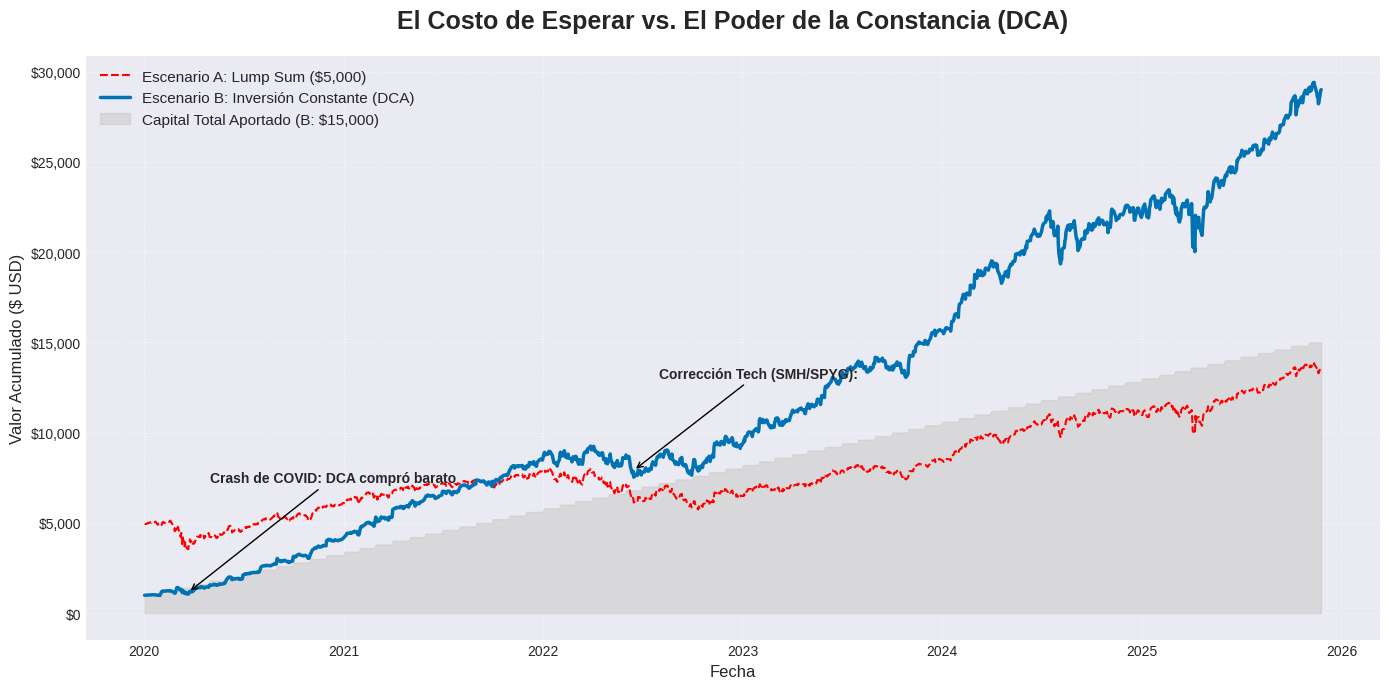

In [11]:

# ----------------------------------------------------
# 7. VISUALIZACIÓN DE AUTORIDAD (MATPLOTLIB)
# ----------------------------------------------------

print("\nGenerando gráfico...")

# Ensure total_invested_B_final is defined for the label, in case previous cell was not run
# This variable is normally calculated in cell yOZ8jOFst_fe
total_invested_B_final = total_invested_B.iloc[-1]

fig, ax = plt.subplots(figsize=(14, 7))

# Título del Gráfico
ax.set_title(
    'El Costo de Esperar vs. El Poder de la Constancia (DCA)',
    fontsize=18,
    fontweight='bold',
    pad=20
)

# 7.1. Plot Escenario A (Lump Sum)
ax.plot(
    portfolio_value_A.index,
    portfolio_value_A.values,
    label=f'Escenario A: Lump Sum (${LUMP_SUM_AMOUNT:,})',
    color='red',
    linestyle='--'
)

# 7.2. Plot Escenario B (Valor de Mercado)
ax.plot(
    portfolio_value_B.index,
    portfolio_value_B.values,
    label=f'Escenario B: Inversión Constante (DCA)',
    color='#0073B4',
    linewidth=2.5
)

# 7.3. Plot Escenario B (Total Invertido - El área sombreada)
# Esto muestra cuánto dinero "salió del bolsillo"
ax.fill_between(
    total_invested_B.index,
    0,
    total_invested_B.values,
    color='#cccccc',
    alpha=0.6,
    label=f'Capital Total Aportado (B: ${total_invested_B_final:,.0f})'
)

# 7.4. ANOTACIONES (Data Storytelling)
# Marcadores para la crisis de COVID y la corrección de 2022
# Localiza la fecha del crash de 2020 y la corrección Tech de 2022
covid_crash_date = '2020-03-23'
tech_correction_date = '2022-06-16'

# Anotación del Crash de 2020
ax.annotate(
    'Crash de COVID: DCA compró barato',
    xy=(pd.to_datetime(covid_crash_date), portfolio_value_B.loc[covid_crash_date] * 1.1),
    xytext=(pd.to_datetime('2020-05-01'), final_value_B * 0.25),
    arrowprops=dict(facecolor='black', arrowstyle="->"),
    fontsize=10,
    fontweight='bold'
)

# Anotación de la corrección de 2022
ax.annotate(
    'Corrección Tech (SMH/SPYG):',
    xy=(pd.to_datetime(tech_correction_date), portfolio_value_B.loc[tech_correction_date] * 1.05),
    xytext=(pd.to_datetime('2022-08-01'), final_value_B * 0.45),
    arrowprops=dict(facecolor='black', arrowstyle="->"),
    fontsize=10,
    fontweight='bold'
)

# Formato de los Ejes
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}')) # Formato de miles en USD
ax.legend(loc='upper left', fontsize=11)
ax.set_ylabel('Valor Acumulado ($ USD)', fontsize=12)
ax.set_xlabel('Fecha', fontsize=12)
ax.grid(True, linestyle=':', alpha=0.7)

# Mejorar el formato del Eje X
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
# Guardar o mostrar el gráfico
# plt.savefig('backtesting_dca_etoro.png', dpi=300)
plt.show()